<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Customer Churn Analysis and Classification

With the rapid development of telecommunication industry, the service providers are inclined more towards expansion of the subscriber base. To meet the need of surviving in the competitive environment, the retention of existing customers has become a huge challenge. It is stated that the cost of acquiring a new customer is far more than that for retaining the existing one. Therefore, it is imperative for the telecom industries to use advanced analytics to understand consumer behavior and in-turn predict the association of the customers as whether or not they will leave the company.

You are given a dataset: each row represents a customer and each column contains attributes related to customer as described:

+ Churn (target): 1 if customer cancelled service, 0 if not
+ AccountWeeks: number of weeks customer has had active account
+ ContractRenewal: 1 if customer recently renewed contract, 0 if not
+ DataPlan: 1 if customer has data plan, 0 if not
+ DataUsage: gigabytes of monthly data usage
+ CustServCalls: number of calls into customer service
+ DayMins: average daytime minutes per month
+ DayCalls: average number of daytime calls
+ MonthlyCharge: average monthly bill
+ OverageFee: largest overage fee in last 12 months
+ RoamMins: average number of roaming minutes


You are asked to **develop an algorithm** to be able to assess which are the customers that have the highest probability to churn. Besides that you will be asked to answer the 3 following questions:

1. **What variables are contributing to customer churn?** 
2. **Who are the customers more likely to churn?**
3. **What actions can be taken to stop them from leaving?**


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create extra variables if needed/possible
3. *Build* your model and test it on the same input data
4. Assess expected accuracy using *cross-validation*
5. Tune the hyperparameters of your model
6. Repeat steps 4 and 5 until you find the best model possible
7. Answer the questions asked

## Main criteria for grading
+ Algorithm implemented
+ AUC score given
+ At least Random Forest and Xgboost are used
+ Data preparation and exploration
+ Hyperparameter optimization 
+ Cross-validation used
+ Code is combined with neat and understandable commentary, with some titles and comments 

In [17]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import *
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True)

### Step 1. *Explore* and understand the dataset. 

In [18]:
# read data
df = pd.read_csv('churn_data.csv', sep=';')

In [19]:
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.10,110,89.00,9.87,10.00
1,0,107,1,1,3.70,1,161.60,123,82.00,9.78,13.70
2,0,137,1,0,0.00,0,243.40,114,52.00,6.06,12.20
3,0,84,0,0,0.00,2,299.40,71,57.00,3.10,6.60
4,0,75,0,0,0.00,3,166.70,113,41.00,7.42,10.10


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [21]:
df.describe()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00
mean,0.14,101.06,0.90,0.28,0.82,1.56,179.78,100.44,56.31,10.05,10.24
std,0.35,39.82,0.30,0.45,1.27,1.32,54.47,20.07,16.43,2.54,2.79
min,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,0.00,0.00
25%,0.00,74.00,1.00,0.00,0.00,1.00,143.70,87.00,45.00,8.33,8.50
50%,0.00,101.00,1.00,0.00,0.00,1.00,179.40,101.00,53.50,10.07,10.30
75%,0.00,127.00,1.00,1.00,1.78,2.00,216.40,114.00,66.20,11.77,12.10
max,1.00,243.00,1.00,1.00,5.40,9.00,350.80,165.00,111.30,18.19,20.00


In [22]:
churn_count_df = df.Churn.value_counts().reset_index().rename(columns={'Churn': 'Count', 'index': 'Churn'})
churn_count_df.Churn = churn_count_df.Churn.astype(object)

In [23]:
fig = px.bar(churn_count_df, x="Churn", y="Count", color='Churn', title="Customer Churn")
fig.show()

Based on barplot above we can observe that 483 customers have churned from total customer base of 3333, which is around 14.5%. Although data is imbalanced still the propotion is not too critical and we can balance it in order to get better performance.


### Step 2. Create extra variables if needed/possible


In [24]:
# define feature and target objects
X = df.drop(columns=['Churn'])
y = df.Churn

In [25]:
# # train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

### 3. *Build* your model and test it on the same input data

#### For this project we examined the data using 3 models: Decision Tree Classifer, Random Forest Classifier, and XGBoost.

# Decision Tree Classifier

In [26]:
# train the model using DecisionTree classifier
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=1)
clf_tree.fit(X, y)

# predict test set labels
y_pred_dt = clf_tree.predict(X)

In [27]:
print('AUC Decision Tree: ', roc_auc_score(y, y_pred_dt))

AUC Decision Tree:  0.7804511278195488


In [28]:
print('Accuracy Score Decision Tree: ', accuracy_score(y, y_pred_dt))

Accuracy Score Decision Tree:  0.9288928892889289


In [29]:
print(classification_report(y, y_pred_dt)) # what is this?

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2850
           1       0.90      0.57      0.70       483

    accuracy                           0.93      3333
   macro avg       0.92      0.78      0.83      3333
weighted avg       0.93      0.93      0.92      3333



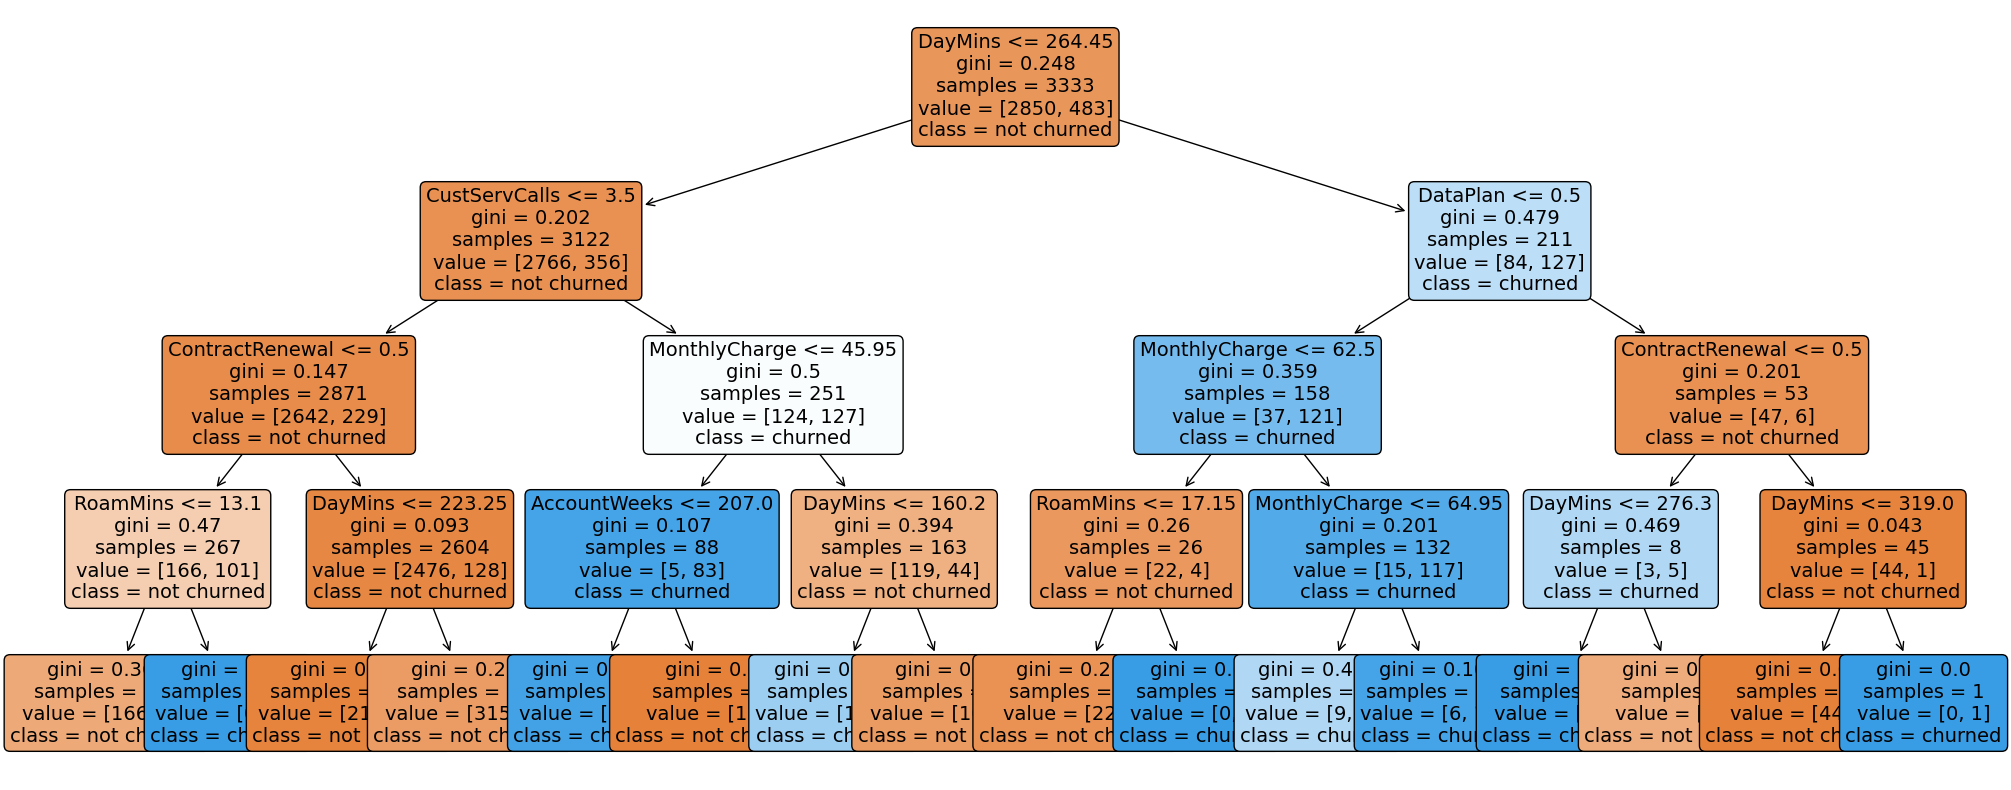

In [30]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,10))
plot_iris = plot_tree(clf_tree,
                      feature_names=X.columns.tolist(), 
                      class_names=['not churned', 'churned'], 
                      filled=True, 
                      rounded=True, 
                      fontsize=14)

# Random Forest Classifier

In [31]:
# Instantiate rf
rf = RandomForestClassifier(max_depth=9, random_state=0)
             
# Fit rf to the training set    
rf.fit(X, y) 
 
# Predict test set labels
y_pred_rf = rf.predict(X)

In [32]:
print('AUC Random Forest: ', roc_auc_score(y, y_pred_rf))

AUC Random Forest:  0.8856020485997602


In [33]:
print('Accuracy Score: ', accuracy_score(y, y_pred_rf))

Accuracy Score:  0.9660966096609661


In [34]:
print(classification_report(y, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2850
           1       0.99      0.77      0.87       483

    accuracy                           0.97      3333
   macro avg       0.98      0.89      0.92      3333
weighted avg       0.97      0.97      0.96      3333



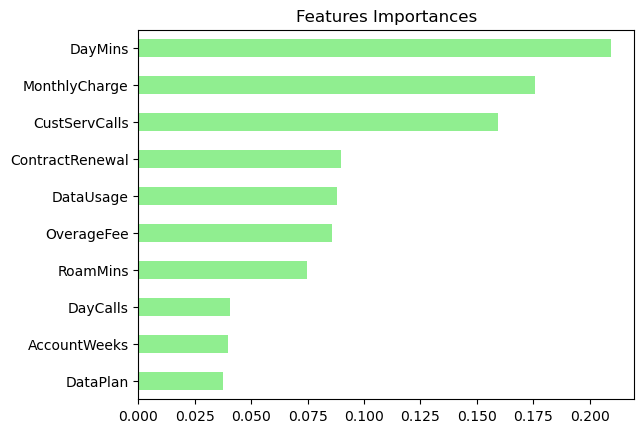

In [35]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X.columns.tolist())
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

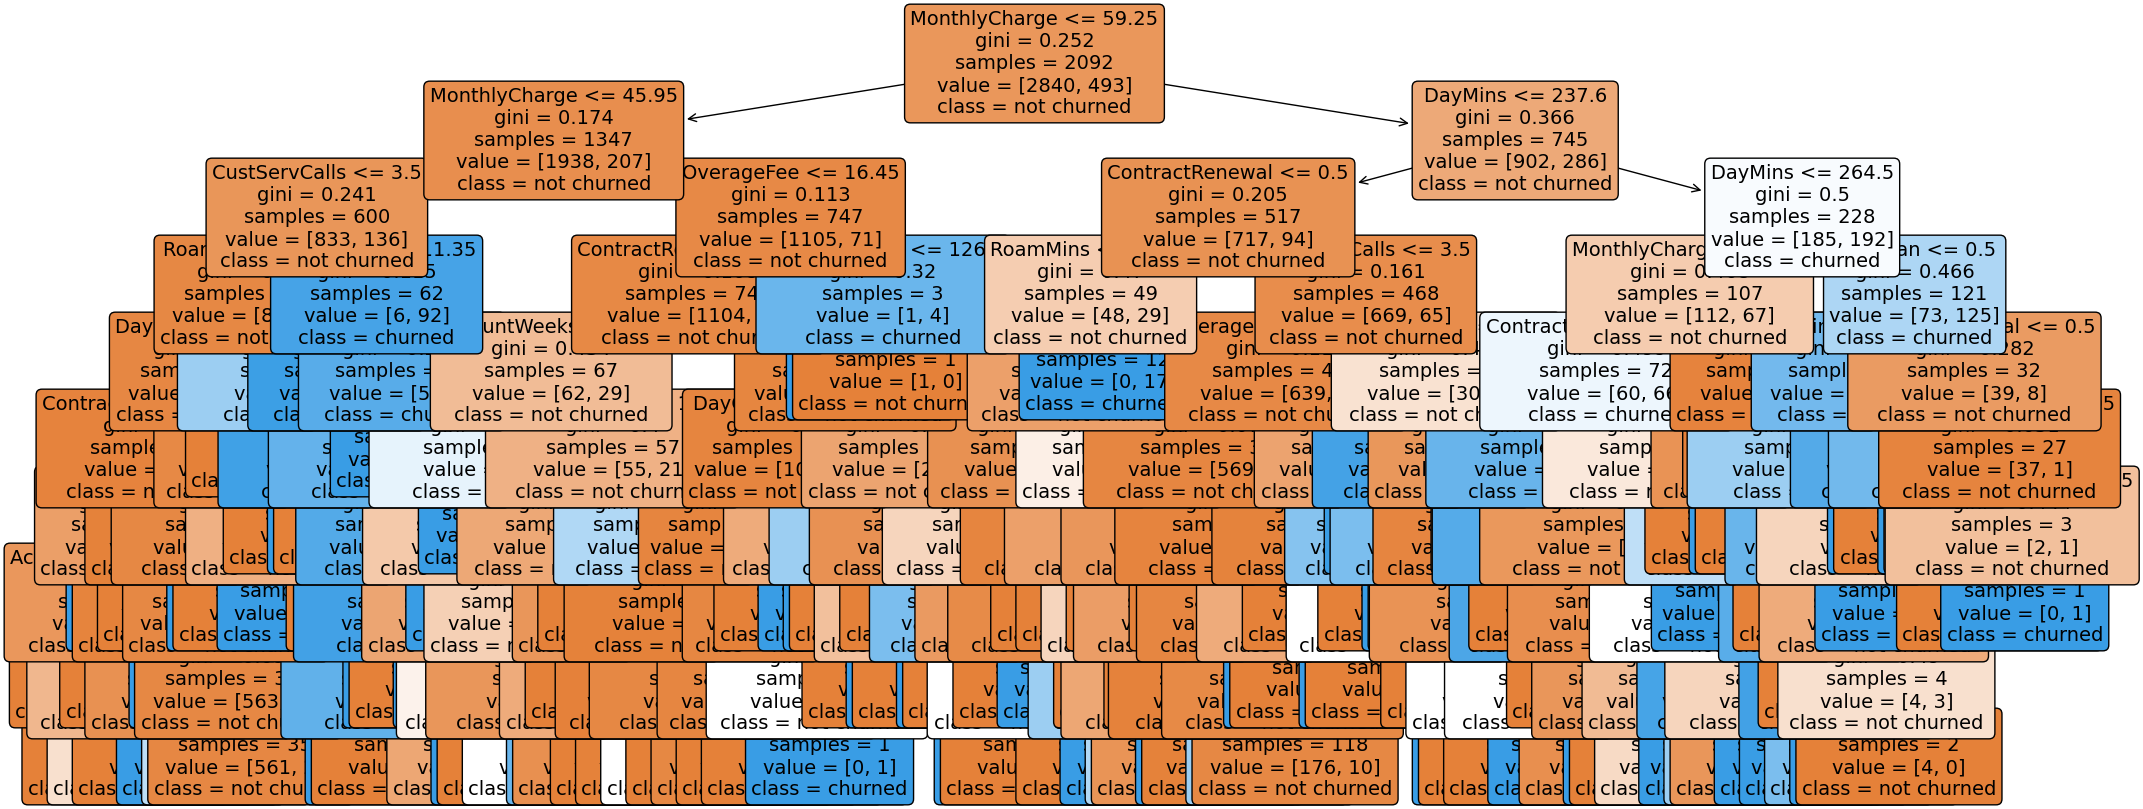

In [37]:
# Extract single tree
estimator = rf.estimators_[1]

plt.figure(figsize=(25,10))
plot_cancer = plot_tree(estimator,
                      feature_names=X.columns.tolist(), 
                      class_names=['not churned', 'churned'], 
                      filled=True, 
                      rounded=True, 
                      fontsize=14)

# XGBoost Classifier

In [38]:
xgb_model = xgb.XGBClassifier()

# Fit to the training set
xgb_model.fit(X, y)

# Compute the probabilities of obtaining the positive class
y_pred_xg = xgb_model.predict(X)

In [39]:
print('AUC XGBoost: ', roc_auc_score(y, y_pred_xg))

AUC XGBoost:  0.994824016563147


In [40]:
print('Accuracy Score: ', accuracy_score(y, y_pred_xg))

Accuracy Score:  0.9984998499849985


In [41]:
print(classification_report(y, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2850
           1       0.99      0.77      0.87       483

    accuracy                           0.97      3333
   macro avg       0.98      0.89      0.92      3333
weighted avg       0.97      0.97      0.96      3333



In [42]:
print('AUC Decision Tree: ', roc_auc_score(y, y_pred_dt))
print('AUC Random Forest: ', roc_auc_score(y, y_pred_rf))
print('AUC XGBoost: ', roc_auc_score(y, y_pred_xg))

AUC Decision Tree:  0.7804511278195488
AUC Random Forest:  0.8856020485997602
AUC XGBoost:  0.994824016563147


##### The Decision Tree (DT) model achieved an AUC score of 78%, but was outperformed by the Random Forest (RF) model by 10%. This is expected since RF includes multiple decison trees whereas DT just includes one. The highest AUC score was achieved using the XGBoost model (AUC of ~99.5%) but this performance result is only valid if we reuse the same dataset that we used to train the model, so it is not representative for other datasets. In the next step we will conduct cross validation and again measure performance to identify more realistic performance of the models

### 4. Assess expected accuracy using *cross-validation*

In [43]:
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=1)
scores_dt = cross_val_score(clf_tree, X, y, cv=5, scoring='roc_auc')

In [44]:
rf = RandomForestClassifier(max_depth=9, random_state=0)
scores_rf = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')

In [45]:
xgb_model = xgb.XGBClassifier(n_estimators=10000, max_depth=20, eval_metric='auc')
scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='roc_auc')

In [46]:
print('Cross Validated AUC Decision Tree: ', scores_dt.mean())
print('Cross Validated AUC Random Forest: ', scores_rf.mean())
print('Cross Validated AUC XGBoost: ', scores_xgb.mean())

Cross Validated AUC Decision Tree:  0.875983507415446
Cross Validated AUC Random Forest:  0.9020912838367396
Cross Validated AUC XGBoost:  0.8809343537107374


##### Interestingly, when using cross validation, the performance of XGBoost model has dropped and the RF model now showcases the highest performance (AUC of 90.2%). When we compare the results from cross validation to the result from step 3, it seems the XGBoost model suffers from overfitting and the RF model is the most robust.

### 5. Tune the hyperparameters of your model

#### Considering what we have observed from the previous steps and the fact that a DT model is not as strong as a RF or XGBoost model, we will be dropping the DT model from our analysis. Below we conduct hyperparameter optimization for the RF and XGBoost models.

 # Random Forest

In [47]:
param_grid = {
    'n_estimators':[100, 300, 600, 800, 1000, 1100],
    'max_features':['log2', 'auto', 'sqrt'],
    'min_samples_leaf':[2, 5, 10, 15, 20],
}

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
 
# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_rf.fit(X, y) 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/MLTreeModelsHW/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'min_samples_leaf': [2, 5, 10, 15, 20],
                         'n_estimators': [100, 300, 600, 800, 1000, 1100]},
             scoring='roc_auc', verbose=2)

In [48]:
grid_search_rf.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}

In [49]:
grid_search_rf.best_score_

0.9034106529209623

##### Performance of RF has increased by around 0.1% utilizing Grid Search

# XGBoost

In [50]:
param_grid = {
    'max_depth': range (4, 16, 2),
    'n_estimators': range(100, 1000, 100),
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
    'eval_metric': ['auc']
}

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
 
# Create a base model
xgb_model = xgb.XGBClassifier()

# Instantiate the grid search model
grid_search_xgb = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_xgb.fit(X, y) 

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['auc'],
                         'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
                         'max_depth': range(4, 16, 2),
                         'n_estimators': range(100, 1000, 100)},
             scoring='roc_auc', verbose=2)

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=300; total time=   0.9s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=600; total time=   1.7s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1000; total time=   2.7s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1100; total time=   3.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=800; total time=   2.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1100; total time=   2.9s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=600; total time=   1.5s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=1000; total time=   2.5s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=15, n_estim

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=600; total time=   1.8s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1000; total time=   2.8s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1100; total time=   3.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=800; total time=   2.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   2.7s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=300; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=600; total time=   1.5s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=800; total time=   2.0s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=1100; total time=   2.7s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=600; total time=   1.4s
[CV] END max_features=log2, min_samples_leaf=15, n_estim

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=600; total time=   1.8s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=800; total time=   2.2s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1100; total time=   3.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=600; total time=   1.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   2.6s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=10, n_estimat

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=300; total time=   0.9s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=600; total time=   1.8s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1000; total time=   2.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=800; total time=   2.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   2.7s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=600; total time=   1.7s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=800; total time=   2.3s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1100; total time=   3.0s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=600; total time=   1.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   2.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1100; total time=   2.9s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=800; total time=   2.0s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=1000; total time=   2.5s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=15, n_estimators=300; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=15, n_estima

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=300; total time=   1.0s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=800; total time=   2.3s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1000; total time=   2.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=600; total time=   1.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=800; total time=   2.1s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1100; total time=   2.9s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=600; total time=   1.5s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=800; total time=   2.0s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=1100; total time=   2.8s
[CV] END max_features=log2, min_samples_leaf=15, n_estimato

[CV] END max_features=log2, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=300; total time=   0.9s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=800; total time=   2.3s
[CV] END max_features=log2, min_samples_leaf=2, n_estimators=1000; total time=   2.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=300; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=600; total time=   1.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   2.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1100; total time=   2.9s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=800; total time=   2.1s
[CV] END max_features=log2, min_samples_leaf=10, n_estimators=1100; total time=   2.7s
[CV] END max_features=log2, min_samples_leaf=15, n_estimato

In [119]:
grid_search_xgb.best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.005,
 'max_depth': 4,
 'n_estimators': 400}

In [120]:
grid_search_xgb.best_score_

0.9022552299993972

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=300; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=400; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=600; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=700; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=900; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=300; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=400; total time=   2.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=600; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=700; total time=   3.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=300; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=400; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=600; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=800; total time=   2.7s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=900; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=300; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   2.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=600; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=800; total time=   4.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=200; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=400; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=600; total time=   1.9s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=700; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=900; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=400; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   2.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=700; total time=   3.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=300; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=500; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=600; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=800; total time=   2.8s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=900; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=400; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=600; total time=   3.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=700; total time=   3.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=900; total time=   4.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=200; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=400; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=500; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=700; total time=   2.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=800; total time=   2.7s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=300; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   2.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=600; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=200; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=300; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=500; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=600; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=800; total time=   2.8s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=300; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=400; total time=   2.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=200; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=300; total time=   0.9s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=500; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=700; total time=   2.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=800; total time=   2.8s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.5s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=400; total time=   2.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   2.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=200; total time=   0.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=400; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=500; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=700; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=4, n_estimators=900; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.0s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=300; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   2.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_depth=6, n_estimators=700; total time=   3.6s
[CV] END eval_metric=auc, learning_rate=0.1, max_d

##### Grid Search has increased the performance of the XGBoost model. Currently, the AUC of XGBoost is 90.2% and now much closer to the RF AUC.

### 6. Repeat steps 4 and 5 until you find the best model possible

#### Optimization Step 4 repeat

## Random Forest

In [139]:
rf_s6 = RandomForestClassifier(max_depth=9, max_features='auto', min_samples_leaf=5, n_estimators=90, random_state=0)
scores_rf_s6 = cross_val_score(rf_s6, X, y, cv=5, scoring='roc_auc')

In [140]:
print('Cross Validated AUC Random Forest: ', scores_rf_s6.mean())

Cross Validated AUC Randome Forest:  0.9056772246337493


## XGBoost

In [141]:
xgb_model_s6 = xgb.XGBClassifier(n_estimators=350, max_depth=4, learning_rate=0.004, eval_metric='auc')
scores_xgb_s6 = cross_val_score(xgb_model_s6, X, y, cv=5, scoring='roc_auc')

In [142]:
print('Cross Validated AUC XGBoost: ', scores_xgb_s6.mean())

Cross Validated AUC XGBoost:  0.9034834132151683


##### Utilizing the derived information about the optimal hyperparameters, the performance of our RF and XGBoost models has improved. 

#### Grid Search Optimization Step 5 repeat

## Random Forest

##### Now let's narrow down the parameter grid to the values identified in previous run for hyperparameter tuning step 5. The fine-tuned hyperparameters identified for the RF model were {'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}

In [121]:
param_grid = {
    'n_estimators':[50, 60, 70, 80, 90, 100, 110, 120, 130],
    'max_features':['log2', 'auto', 'sqrt'],
    'min_samples_leaf':[5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}
 
# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_rf_s6 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_rf_s6.fit(X, y) 

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dyada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'min_samples_leaf': [5, 7, 8, 9, 10, 11, 12, 13, 14,
                                              15],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130]},
             scoring='roc_auc', verbose=2)

[CV] END max_features=log2, min_samples_leaf=5, n_estimators=60; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=70; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=90; total time=   0.5s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=110; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=120; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=70; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=80; total time=   0.5s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=110; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=130; total 

[CV] END max_features=log2, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=60; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=80; total time=   0.5s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=90; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=110; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=130; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=60; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=70; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=90; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=110; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=120; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=8, n_estimators=50; total t

[CV] END max_features=log2, min_samples_leaf=5, n_estimators=60; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=70; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=90; total time=   0.5s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=120; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=60; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=80; total time=   0.5s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=90; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=110; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=120; total t

[CV] END max_features=log2, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=70; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=80; total time=   0.5s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=120; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=130; total time=   0.8s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=70; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=80; total time=   0.5s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=120; total time=   0.7s
[CV] END max_features=log2, min_samples_leaf=7, n_estimators=130; total time=   0.9s
[CV] END max_features=log2, min_samples_leaf=8, n_estimators=60; total

In [124]:
grid_search_rf_s6.best_params_

{'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 90}

In [123]:
grid_search_rf_s6.best_score_

0.9055326460481101

##### After narrowing down Grid Search for the RF model we have achieved a performace increase of 0.2%, raising the overall score to higher 90.5%

## XGBoost

##### Let's try to optimize more XGBoost Grid Search from optimal hyperparameters found in step 5 {'eval_metric': 'auc', 'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 400}

In [126]:
param_grid = {
    'max_depth': range (4, 16, 2),
    'n_estimators': range(300, 500, 25),
    'learning_rate': [ 0.01, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001],
    'eval_metric': ['auc']
}
 
# Create a base model
xgb_model = xgb.XGBClassifier()

# Instantiate the grid search model
grid_search_xgb_s6 = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

# Fit the grid search to the data
grid_search_xgb_s6.fit(X, y) 

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['auc'],
                         'learning_rate': [0.01, 0.008, 0.007, 0.006, 0.005,
                                           0.004, 0.003, 0.002, 0.001],
                         'max_depth': range(4, 16, 2),
                         'n_estimators': range(300, 500, 25)},
             scoring='roc_auc', verbose=2)

In [127]:
grid_search_xgb_s6.best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.004,
 'max_depth': 4,
 'n_estimators': 350}

In [128]:
grid_search_xgb_s6.best_score_

0.9034834132151683

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=325; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=350; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=400; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=450; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=475; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=325; total time=   1.9s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=350; total time=   2.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=400; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=450; total time=   3.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=475; total time=   3.2s
[CV] END eval_metric=auc, learning_rate=

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=300; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=350; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=400; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=425; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=475; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=300; total time=   1.8s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=350; total time=   2.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=400; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=425; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=475; total time=   3.3s
[CV] END eval_metric=auc, learning_rate=

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=300; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=350; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=375; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=425; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=450; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=300; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=350; total time=   2.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=375; total time=   2.8s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=425; total time=   3.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=475; total time=   3.2s
[CV] END eval_metric=auc, learning_rate=

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=325; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=350; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=400; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=425; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=475; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=325; total time=   1.9s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=350; total time=   2.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=400; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=425; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=475; total time=   3.3s
[CV] END eval_metric=auc, learning_rate=

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=325; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=375; total time=   1.3s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=400; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=450; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=475; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=325; total time=   1.9s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=375; total time=   2.4s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=400; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=450; total time=   3.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=475; total time=   3.2s
[CV] END eval_metric=auc, learning_rate=

[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=300; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=325; total time=   1.2s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=375; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=400; total time=   1.5s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=4, n_estimators=450; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=300; total time=   1.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=325; total time=   2.0s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=375; total time=   2.6s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=400; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=0.01, max_depth=6, n_estimators=450; total time=   3.1s
[CV] END eval_metric=auc, learning_rate=

##### Again, narrowing down the hyperparameter ranges has helped. The AUC of our XGBoost model has improved by 0.1%

### 7. Answer the questions asked

**1. What variables are contributing to customer churn?** 

### Random Forest Model

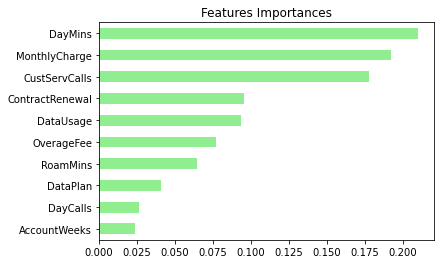

In [145]:
rf_s6_f = rf_s6.fit(X, y)
# Create a pd.Series of features importances
importances = pd.Series(data=rf_s6_f.feature_importances_,
                        index= X.columns.tolist())
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

## XGBoost

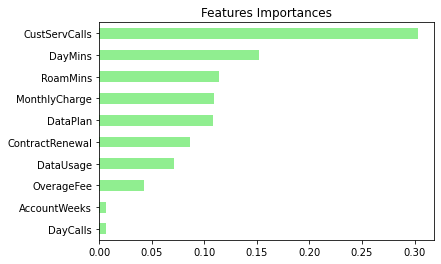

In [146]:
xgb_model_s6_f = xgb_model_s6.fit(X, y)
# Create a pd.Series of features importances
importances = pd.Series(data=xgb_model_s6_f.feature_importances_,
                        index= X.columns.tolist())
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

##### Interestingly, the most dominant feature in case of RF seems to be average daytime minutes per month, whereas XGBoost has identified number of calls into customer service as the one having most predictive power for churn prediction. However, average daytime minutes per month seems to be real important as well as XGBoost has detected it to be 2nd most important feature in the levels of the customer churn.

##### Average monthly bill and average number of roaming minutes also seems to have high impact on the customer churn.

**2. Who are the customers more likely to churn?**

##### To understand which customers are more likely to churn we need to visualize sample of trees to have some understanding how each feature affect probability of churning i.e. increase/decrease 

## Random Forest

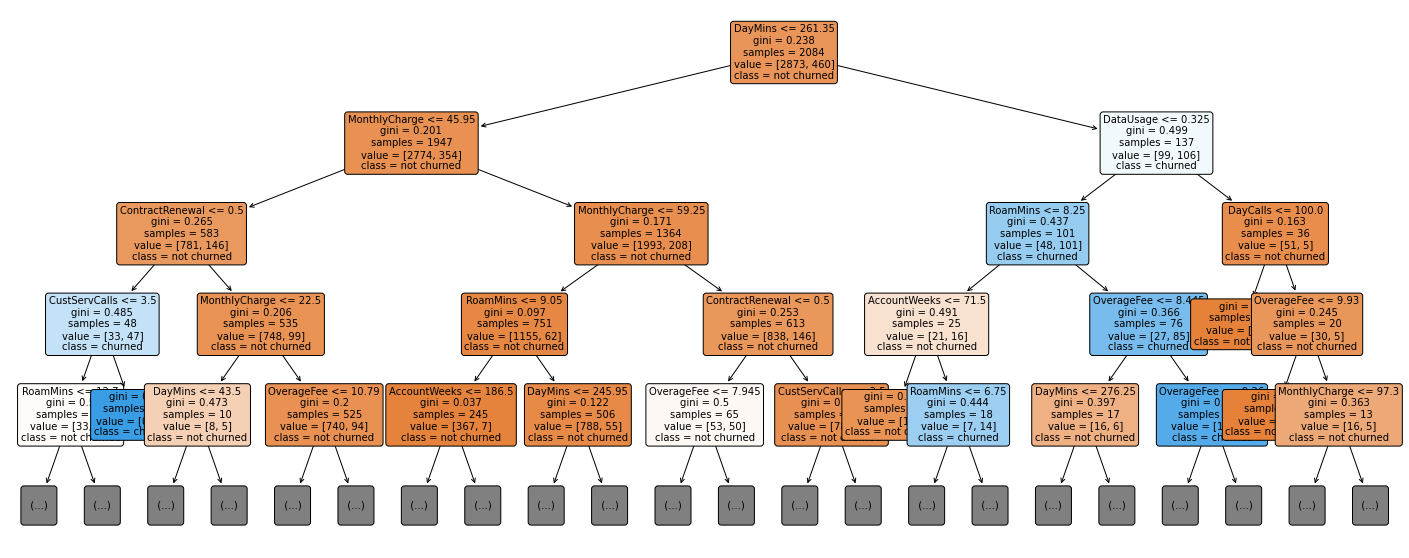

In [176]:
# Extract single tree
estimator = rf_s6.estimators_[2]

plt.figure(figsize=(25,10))
plot_cancer = plot_tree(estimator,
                      feature_names=X.columns.tolist(), 
                      class_names=['not churned', 'churned'], 
                      filled=True, 
                      rounded=True, 
                      fontsize=10,
                      max_depth=4)

In [166]:
tree_rules = export_text(rf_s6.estimators_[2], feature_names=list(X.columns),  max_depth=3, show_weights=True)

In [167]:
print(tree_rules)

|--- DayMins <= 261.35
|   |--- MonthlyCharge <= 45.95
|   |   |--- ContractRenewal <= 0.50
|   |   |   |--- CustServCalls <= 3.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- CustServCalls >  3.50
|   |   |   |   |--- weights: [0.00, 15.00] class: 1.0
|   |   |--- ContractRenewal >  0.50
|   |   |   |--- MonthlyCharge <= 22.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- MonthlyCharge >  22.50
|   |   |   |   |--- truncated branch of depth 6
|   |--- MonthlyCharge >  45.95
|   |   |--- MonthlyCharge <= 59.25
|   |   |   |--- RoamMins <= 9.05
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- RoamMins >  9.05
|   |   |   |   |--- truncated branch of depth 6
|   |   |--- MonthlyCharge >  59.25
|   |   |   |--- ContractRenewal <= 0.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- ContractRenewal >  0.50
|   |   |   |   |--- truncated branch of depth 6
|--- DayMins >  261.35
|   |--- DataUsage <= 0.33
|   |   |--

##### Above we can observe both decision path of RF 2nd estimator or tree. It has started from DayMins (average daytime minutes per month) which is consitent from previous steps and if average daytime minutes per month <= 261.35 we go to left branch of the tree where proportion of customer not churned is 2774 and churned 354. While is average daytime minutes per month > 261.35 dominant class is churned 106 customer have churned and and 99 not churned. If we continue with last branch if gigabytes of monthly data usage <= 0.325 then customer will be more likely to churn 101 churned vs 48 not churned. However, customer who had gigabytes of monthly data usage > 0.325 are much likely to churn as dominant class there is not churned 51 customer

3. **What actions can be taken to stop them from leaving?**

+ Churn (target): 1 if customer cancelled service, 0 if not
+ AccountWeeks: number of weeks customer has had active account
+ ContractRenewal: 1 if customer recently renewed contract, 0 if not
+ DataPlan: 1 if customer has data plan, 0 if not
+ DataUsage: gigabytes of monthly data usage
+ CustServCalls: number of calls into customer service
+ DayMins: average daytime minutes per month
+ DayCalls: average number of daytime calls
+ MonthlyCharge: average monthly bill
+ OverageFee: largest overage fee in last 12 months
+ RoamMins: average number of roaming minutes

# To be done!!!

-  2. Create extra variables if needed/possible
-  7. Answer the questions asked

### maybe useful>> https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc